In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Loading Data

In [86]:
df = pd.read_csv('data/raw/games.csv')

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71716 entries, 0 to 71715
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   AppID                       71716 non-null  int64  
 1   Name                        71715 non-null  object 
 2   Release date                71716 non-null  object 
 3   Estimated owners            71716 non-null  object 
 4   Peak CCU                    71716 non-null  int64  
 5   Required age                71716 non-null  int64  
 6   Price                       71716 non-null  float64
 7   DLC count                   71716 non-null  int64  
 8   About the game              69280 non-null  object 
 9   Supported languages         71716 non-null  object 
 10  Full audio languages        71716 non-null  object 
 11  Reviews                     9167 non-null   object 
 12  Header image                71716 non-null  object 
 13  Website                     350

# Data Cleaning

In [88]:
drop_columns = [
    'Header image', 'Website', 'Support url', 'Support email',
    'Metacritic url', 'Screenshots', 'Movies', 'Score rank',
    'Notes', 'Estimated owners', 'Peak CCU', 'DLC count',
    'Full audio languages', 'Reviews',
    'Average playtime two weeks', 'Median playtime two weeks',
    'Support email', 'Support url'
]
df_clean = df.drop(columns=drop_columns)

In [89]:
df_clean.columns.tolist()

['AppID',
 'Name',
 'Release date',
 'Required age',
 'Price',
 'About the game',
 'Supported languages',
 'Windows',
 'Mac',
 'Linux',
 'Metacritic score',
 'User score',
 'Positive',
 'Negative',
 'Achievements',
 'Recommendations',
 'Average playtime forever',
 'Median playtime forever',
 'Developers',
 'Publishers',
 'Categories',
 'Genres',
 'Tags']

In [90]:
df_clean.head()

,AppID,Name,Release date,Required age,Price,About the game,Supported languages,Windows,Mac,Linux,...,Negative,Achievements,Recommendations,Average playtime forever,Median playtime forever,Developers,Publishers,Categories,Genres,Tags
0,20200,Galactic Bowling,"Oct 21, 2008",0,19.99,Galactic Bowling is an exaggerated and stylize...,['English'],True,False,False,...,11,30,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling"
1,655370,Train Bandit,"Oct 12, 2017",0,0.99,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",True,True,False,...,5,12,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc..."
2,1732930,Jolt Project,"Nov 17, 2021",0,4.99,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",True,False,False,...,0,0,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",NaN
3,1355720,Henosis™,"Jul 23, 2020",0,5.99,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",True,True,True,...,0,0,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz..."
4,1139950,Two Weeks in Painland,"Feb 3, 2020",0,0.00,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",True,True,False,...,8,17,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,..."


## Preprocessing of text data

In [91]:
def split_tags(tags_str):
    if pd.isna(tags_str) or tags_str == '':
        return []
    return [tag.strip() for tag in str(tags_str).split(',')]

In [92]:
df_clean['Tags_list'] = df_clean['Tags'].apply(split_tags)
df_clean['Genres_list'] = df_clean['Genres'].apply(split_tags) 
df_clean['Categories_list'] = df_clean['Categories'].apply(split_tags)

In [93]:
df_clean['Tags_list'].head(3).values

array([list(['Indie', 'Casual', 'Sports', 'Bowling']),
       list(['Indie', 'Action', 'Pixel Graphics', '2D', 'Retro', 'Arcade', 'Score Attack', 'Minimalist', 'Comedy', 'Singleplayer', 'Fast-Paced', 'Casual', 'Funny', 'Parody', 'Difficult', 'Gore', 'Violent', 'Western', 'Controller', 'Blood']),
       list([])], dtype=object)

## Popular tags analysis

In [94]:
all_tags = []
for tag_list in df_clean['Tags_list']:
    all_tags.extend(tag_list)

In [95]:
tag_counts = pd.Series(all_tags).value_counts()

In [96]:
tag_counts.head(20)

Indie             37158
Singleplayer      28804
Action            26011
Casual            24905
Adventure         24197
2D                15291
Strategy          12308
Simulation        12051
RPG               10689
Puzzle            10193
Atmospheric        9821
3D                 8114
Early Access       8108
Pixel Graphics     7984
Story Rich         7858
Colorful           7475
Multiplayer        7068
Cute               6893
Arcade             6852
First-Person       6569
Name: count, dtype: int64

### Top 20 Most Popular Tags on Steam

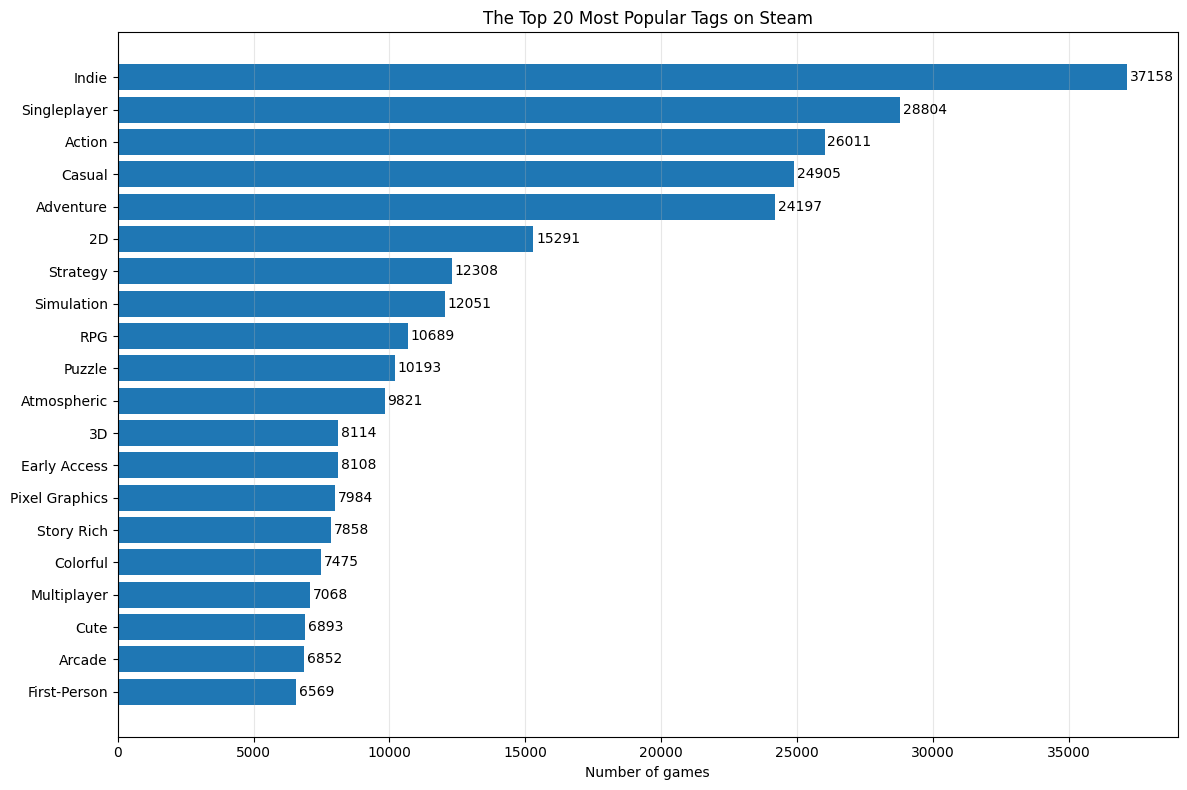

In [97]:
plt.figure(figsize=(12, 8))
top_20 = tag_counts.head(20).sort_values(ascending=True)
bars = plt.barh(range(len(top_20)), top_20.values)

plt.yticks(range(len(top_20)), top_20.index)
plt.title('The Top 20 Most Popular Tags on Steam')
plt.xlabel('Number of games')
plt.grid(axis='x', alpha=0.3)

for i, bar in enumerate(bars):
    plt.text(bar.get_width() + 100, bar.get_y() + bar.get_height()/2, 
             f'{int(bar.get_width())}', ha='left', va='center')

plt.tight_layout()
plt.show()

### Tags for ML

In [98]:
TOP_N_TAGS = 50
useful_tags = tag_counts.head(TOP_N_TAGS).index.tolist()

In [99]:
for tag in useful_tags:
    df_clean[f'tag_{tag}'] = df_clean['Tags_list'].apply(lambda x: 1 if tag in x else 0)

In [100]:
df_clean.head()

,AppID,Name,Release date,Required age,Price,About the game,Supported languages,Windows,Mac,Linux,...,tag_Top-Down,tag_Violent,tag_Comedy,tag_FPS,tag_Visual Novel,tag_Co-op,tag_Stylized,tag_Controller,tag_2D Platformer,tag_Minimalist
0,20200,Galactic Bowling,"Oct 21, 2008",0,19.99,Galactic Bowling is an exaggerated and stylize...,['English'],True,False,False,...,0,0,0,0,0,0,0,0,0,0
1,655370,Train Bandit,"Oct 12, 2017",0,0.99,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",True,True,False,...,0,1,1,0,0,0,0,1,0,1
2,1732930,Jolt Project,"Nov 17, 2021",0,4.99,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",True,False,False,...,0,0,0,0,0,0,0,0,0,0
3,1355720,Henosis™,"Jul 23, 2020",0,5.99,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",True,True,True,...,0,0,0,0,0,0,1,0,1,0
4,1139950,Two Weeks in Painland,"Feb 3, 2020",0,0.00,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",True,True,False,...,0,1,0,0,0,0,0,0,0,0


## Popular genre analysis

In [101]:
all_genres = []
for genre_list in df_clean['Genres_list']:
    all_genres.extend(genre_list)
genre_counts = pd.Series(all_genres).value_counts()

In [102]:
genre_counts.head(10)

Indie           48827
Action          28870
Casual          28817
Adventure       26634
Simulation      13590
Strategy        13218
RPG             12079
Early Access     8337
Free to Play     5638
Sports           3184
Name: count, dtype: int64

### Top 10 most popular genre on steam

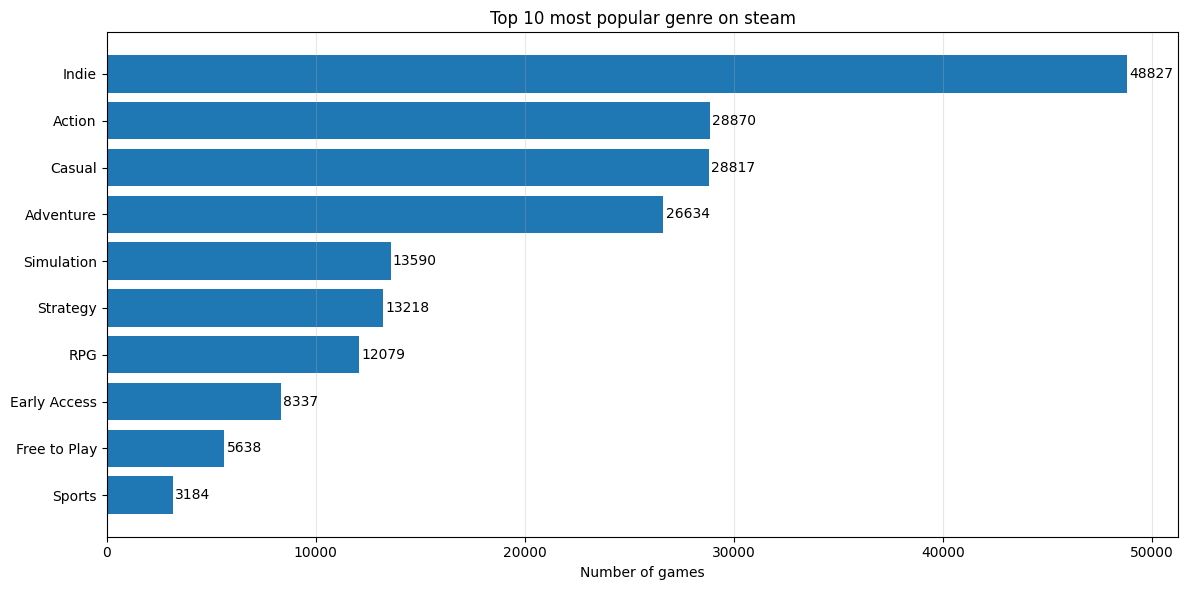

In [103]:
plt.figure(figsize=(12, 6))
top_genres = genre_counts.head(10).sort_values(ascending=True)
bars = plt.barh(range(len(top_genres)), top_genres.values)

plt.yticks(range(len(top_genres)), top_genres.index)
plt.title('Top 10 most popular genre on steam')
plt.xlabel('Number of games')
plt.grid(axis='x', alpha=0.3)

for i, bar in enumerate(bars):
    plt.text(bar.get_width() + 100, bar.get_y() + bar.get_height()/2, 
             f'{int(bar.get_width())}', ha='left', va='center')

plt.tight_layout()
plt.show()

### Tags for genre

In [104]:
for genre in genre_counts.index:
    df_clean[f'genre_{genre}'] = df_clean['Genres_list'].apply(lambda x: 1 if genre in x else 0)

In [105]:
df_clean.head()

,AppID,Name,Release date,Required age,Price,About the game,Supported languages,Windows,Mac,Linux,...,genre_Nudity,genre_Sexual Content,genre_Web Publishing,genre_Accounting,genre_Movie,genre_Documentary,genre_Episodic,genre_Short,genre_Tutorial,genre_360 Video
0,20200,Galactic Bowling,"Oct 21, 2008",0,19.99,Galactic Bowling is an exaggerated and stylize...,['English'],True,False,False,...,0,0,0,0,0,0,0,0,0,0
1,655370,Train Bandit,"Oct 12, 2017",0,0.99,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",True,True,False,...,0,0,0,0,0,0,0,0,0,0
2,1732930,Jolt Project,"Nov 17, 2021",0,4.99,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",True,False,False,...,0,0,0,0,0,0,0,0,0,0
3,1355720,Henosis™,"Jul 23, 2020",0,5.99,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",True,True,True,...,0,0,0,0,0,0,0,0,0,0
4,1139950,Two Weeks in Painland,"Feb 3, 2020",0,0.00,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",True,True,False,...,0,0,0,0,0,0,0,0,0,0


## Popular categories analisys

In [106]:
all_categories = []
for cat_list in df_clean['Categories_list']:
    all_categories.extend(cat_list)
category_counts = pd.Series(all_categories).value_counts()

In [107]:
category_counts.head(15)

Single-player                 64927
Steam Achievements            31992
Steam Cloud                   16289
Full controller support       13748
Multi-player                  13495
Steam Trading Cards            9531
Partial Controller Support     9283
PvP                            8506
Co-op                          6667
Steam Leaderboards             6149
Online PvP                     6022
Remote Play Together           5539
Shared/Split Screen            5031
Online Co-op                   3670
Shared/Split Screen PvP        3656
Name: count, dtype: int64

### Top 15 most popular categories

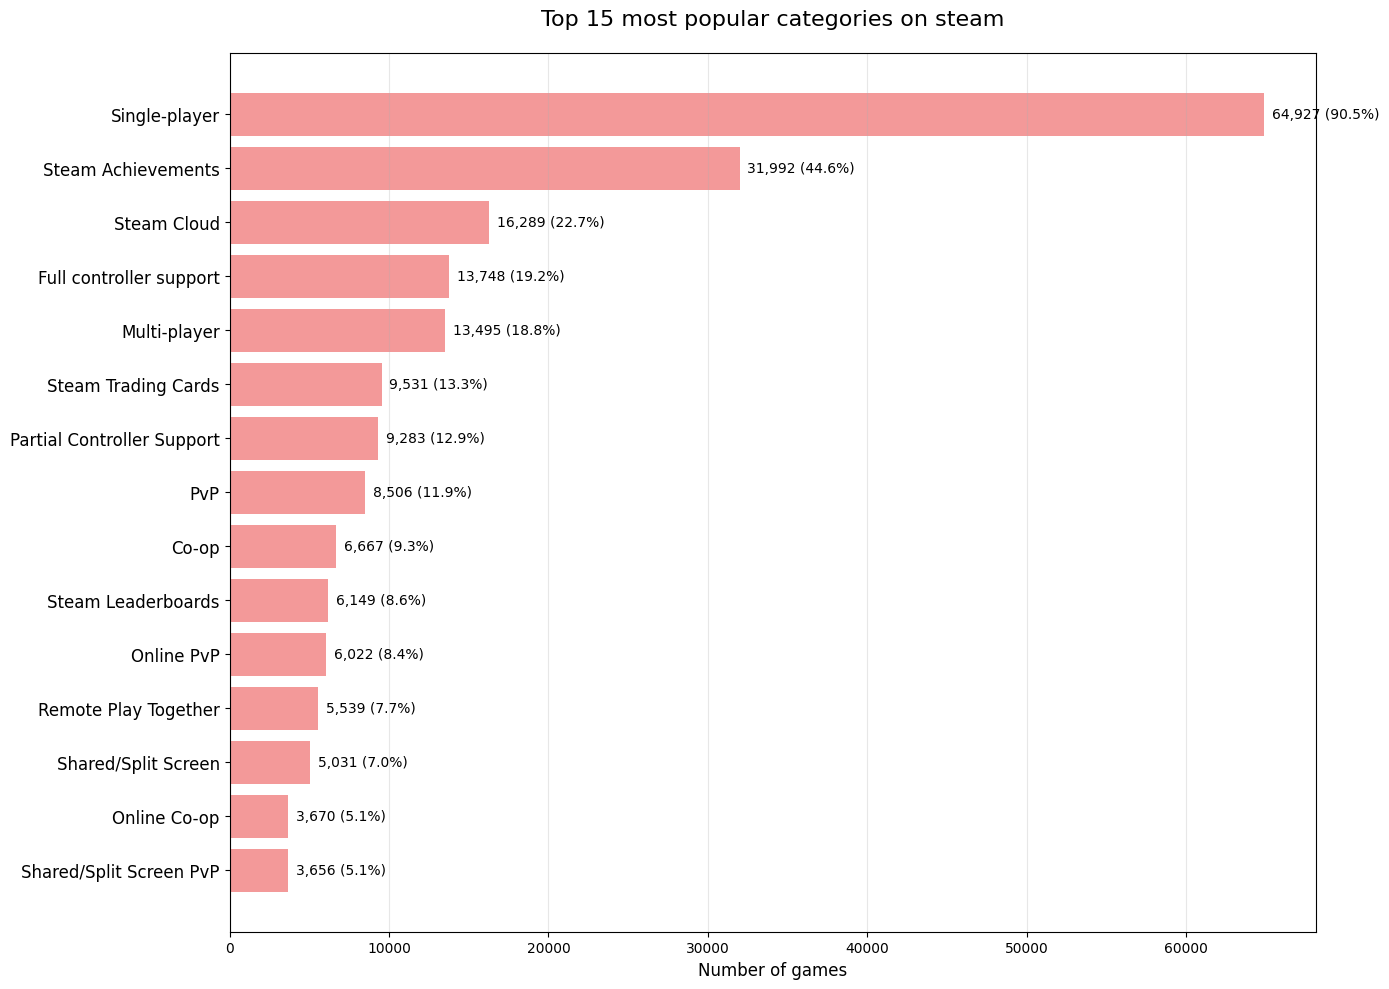

In [108]:
plt.figure(figsize=(14, 10))
top_categories = category_counts.head(15).sort_values(ascending=True)
bars = plt.barh(range(len(top_categories)), top_categories.values, 
                color='lightcoral', alpha=0.8)

plt.yticks(range(len(top_categories)), top_categories.index, fontsize=12)
plt.title('Top 15 most popular categories on steam', fontsize=16, pad=20)
plt.xlabel('Number of games', fontsize=12)
plt.grid(axis='x', alpha=0.3)

total_games = len(df_clean)
for i, bar in enumerate(bars):
    count = int(bar.get_width())
    percentage = (count / total_games) * 100
    plt.text(bar.get_width() + 500, bar.get_y() + bar.get_height()/2, 
             f'{count:,} ({percentage:.1f}%)', 
             ha='left', va='center', fontsize=10)

plt.tight_layout()
plt.show()

### Tags for categories

In [109]:
top_categories = category_counts.head(15).index
new_columns = {}
for category in top_categories:
    col_name = f'category_{category.replace(" ", "_").replace("/", "_")}'
    new_columns[col_name] = df_clean['Categories_list'].apply(lambda x: 1 if category in x else 0)

df_clean = pd.concat([df_clean, pd.DataFrame(new_columns)], axis=1)

In [111]:
df_clean.head()

,AppID,Name,Release date,Required age,Price,About the game,Supported languages,Windows,Mac,Linux,...,category_Steam_Trading_Cards,category_Partial_Controller_Support,category_PvP,category_Co-op,category_Steam_Leaderboards,category_Online_PvP,category_Remote_Play_Together,category_Shared_Split_Screen,category_Online_Co-op,category_Shared_Split_Screen_PvP
0,20200,Galactic Bowling,"Oct 21, 2008",0,19.99,Galactic Bowling is an exaggerated and stylize...,['English'],True,False,False,...,0,1,0,0,0,0,0,0,0,0
1,655370,Train Bandit,"Oct 12, 2017",0,0.99,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",True,True,False,...,0,0,0,0,1,0,0,0,0,0
2,1732930,Jolt Project,"Nov 17, 2021",0,4.99,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",True,False,False,...,0,0,0,0,0,0,0,0,0,0
3,1355720,Henosis™,"Jul 23, 2020",0,5.99,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",True,True,True,...,0,0,0,0,0,0,0,0,0,0
4,1139950,Two Weeks in Painland,"Feb 3, 2020",0,0.00,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",True,True,False,...,0,0,0,0,0,0,0,0,0,0
